<a href="https://colab.research.google.com/github/Meghana-Yarlagadda/Fashion-image-classification/blob/main/fashion_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5), (0.5))
])

dataset = torchvision.datasets.FashionMNIST('.data/', download=True, train=True, transform=trans)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]


Extracting .data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]


Extracting .data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]


Extracting .data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]

Extracting .data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



In [4]:
dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
classes = list(dataset.class_to_idx.keys())

In [6]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

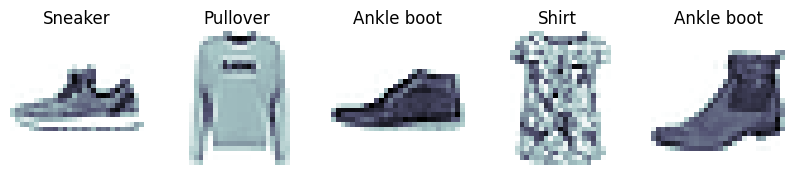

In [7]:
fig, axes = plt.subplots(1,5, figsize=(10,2))

for ax in axes.ravel():
  r = next(iter(dataloader))
  ax.imshow(r[0].numpy()[1].reshape(28,28), cmap='bone_r')
  ax.set_title(classes[r[1].numpy()[1]])
  ax.axis('off')


In [8]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(784, 400)
    self.mu = nn.Linear(400, 20)
    self.sigma = nn.Linear(400, 20)
    self.upscale_sample = nn.Linear(20,400)
    self.output_layer = nn.Linear(400, 784)

  def encode(self, x):
    x = F.relu(self.input_layer(x))
    return self.mu(x), self.sigma(x)

  def parametric(self, mu, sigma):
    std = sigma.exp()

    if torch.cuda.is_available():
      sample = torch.cuda.FloatTensor(mu.size()).normal_()
    else:
      sample = torch.FloatTensor(mu.size()).normal_()

    sample = Variable(sample)

    return sample.mul(std).add(mu)

  def decode(self, sample):
    x = F.relu(self.upscale_sample(sample))
    return torch.sigmoid(self.output_layer(x))


  def forward(self, x):
    mu, sigma = self.encode(x)
    sample = self.parametric(mu, sigma)

    return self.decode(sample), mu, sigma

In [9]:
model = VAE().to(device)

In [10]:
model

VAE(
  (input_layer): Linear(in_features=784, out_features=400, bias=True)
  (mu): Linear(in_features=400, out_features=20, bias=True)
  (sigma): Linear(in_features=400, out_features=20, bias=True)
  (upscale_sample): Linear(in_features=20, out_features=400, bias=True)
  (output_layer): Linear(in_features=400, out_features=784, bias=True)
)

In [11]:
def loss_function(reconstructed, real, mu, sigma):
  image_loss = nn.MSELoss(reduction='sum')(reconstructed, real)

  kl_loss = -0.5*(torch.sum(1+sigma - mu.pow(2) - sigma.exp()))

  return image_loss, kl_loss

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
epochs = 10

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}/{epochs}")

    train_loss_im, train_loss_kl = 0, 0
    correct_reconstructions = 0
    total_samples = 0

    for b, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)

        optimizer.zero_grad()

        # Forward pass
        recons, mu, sigma = model(img)

        # Compute losses
        loss_im, loss_kl = loss_function(recons, img, mu, sigma)
        loss = loss_im + loss_kl

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate losses
        train_loss_im += loss_im.item()
        train_loss_kl += loss_kl.item()

        # Compute accuracy (assuming reconstruction threshold)
        predicted = (recons > 0.5).float()  # Assuming pixel values are normalized between 0 and 1
        correct_reconstructions += (predicted == img).sum().item()
        total_samples += img.numel()

    # Compute average loss and pseudo-accuracy
    avg_loss_im = train_loss_im / len(dataloader)
    avg_loss_kl = train_loss_kl / len(dataloader)
    accuracy = 100 * correct_reconstructions / total_samples

    print(f"Epoch {epoch+1}: Loss (Reconstruction): {avg_loss_im:.4f}, KL Loss: {avg_loss_kl:.4f}, Accuracy: {accuracy:.2f}%")


Epoch: 1/10


<ipython-input-8-607ecad2f797>:18: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  sample = torch.cuda.FloatTensor(mu.size()).normal_()


Epoch 1: Loss (Reconstruction): 64382.1650, KL Loss: 1147.2867, Accuracy: 0.24%
Epoch: 2/10
Epoch 2: Loss (Reconstruction): 61449.7519, KL Loss: 879.8503, Accuracy: 0.40%
Epoch: 3/10
Epoch 3: Loss (Reconstruction): 60904.7268, KL Loss: 879.7227, Accuracy: 0.45%
Epoch: 4/10
Epoch 4: Loss (Reconstruction): 60616.6563, KL Loss: 879.6653, Accuracy: 0.48%
Epoch: 5/10
Epoch 5: Loss (Reconstruction): 60430.5094, KL Loss: 874.5411, Accuracy: 0.50%
Epoch: 6/10
Epoch 6: Loss (Reconstruction): 60288.4274, KL Loss: 872.7146, Accuracy: 0.52%
Epoch: 7/10
Epoch 7: Loss (Reconstruction): 60188.3524, KL Loss: 872.4366, Accuracy: 0.53%
Epoch: 8/10
Epoch 8: Loss (Reconstruction): 60104.9236, KL Loss: 871.9297, Accuracy: 0.54%
Epoch: 9/10
Epoch 9: Loss (Reconstruction): 60038.8233, KL Loss: 875.6711, Accuracy: 0.55%
Epoch: 10/10
Epoch 10: Loss (Reconstruction): 59980.9928, KL Loss: 877.5402, Accuracy: 0.56%


[]

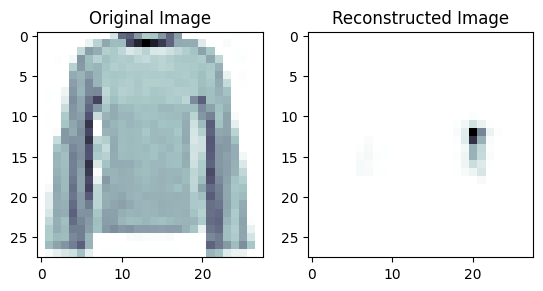

In [14]:
model.eval()

ev_img = next(iter(dataloader))[0].numpy()[1].reshape(28,28)

ev_img_r = ev_img.ravel()
#model= dnn.read(mm.weight,mm.cfg)

ev_mu, ev_sigma = model.encode(torch.from_numpy(ev_img_r).cuda())

ev_param_tensor = model.parametric(ev_mu, ev_sigma)

ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)

fig, ax = plt.subplots(1,2)

ax[0].set_title('Original Image')

ax[0].imshow(ev_img, cmap='bone_r')

ax[1].set_title('Reconstructed Image')

ax[1].imshow(ev_out, cmap='bone_r')

plt.plot()